## L2 norm estimation of the equivalent layer parameters

This notebook evaluates the predicted data obtained by an equivalent layer located at a specific depth.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from coord import GGS
from equiv_layer import EqLayer
from carto_map_plot import point_map
import config_style_plot as style

# Redefining functions
geodetic2cartesian = GGS().geodetic2cartesian
rotation_matrix = GGS().rotation_matrix
# Plot style
style.plot_params()

In [2]:
def L1_estim(rcl, pcl, Acc_l, it_max):
    for i in range(it_max):
#         print i
        res = rcl - np.dot(Acc_l, pcl)
        W = np.dot(Acc_l.T, np.diag(1./(np.abs(res)+1e-10)) )
        pcl = np.linalg.solve(np.dot(W, Acc_l), np.dot(W, rcl))
    return pcl

In [3]:
# IMPORTING BDG FILE
header=['LONG', 'LAT', 'ALT_GEOM', 'GRAV']
path = '../data/BDG/'
uf = 'AM'
name_bdg = '_file.txt'
bdg = pd.read_csv('{p}{u}{ne}'.format(p=path,u=uf,ne=name_bdg), sep='\s+',names=header, skiprows=1)
# bdg

In [4]:
# IMPORTING EIGEN FILE
name_eigen = '.dat'
eigen = pd.read_csv('{p}{u}{ne}'.format(p=path,u=uf,ne=name_eigen), sep='\s+',skiprows=32, \
                    usecols=(4,), names=['GRAV'])
# eigen

In [5]:
# Obtaining short wavelength signals
disturb = bdg.GRAV.values - eigen.GRAV.values

data = {'LONG':bdg.LONG.values, \
        'LAT':bdg.LAT.values, \
        'ALT':bdg.ALT_GEOM.values, \
        'BDG':bdg.GRAV.values, \
        'EIGEN':eigen.GRAV.values, \
        'DIST':disturb}
df = pd.DataFrame(data)
df

,LONG,LAT,ALT,BDG,EIGEN,DIST
0,-63.12500,-4.054700,20.110,978000.47,978000.697913,-0.227913
1,-63.08250,-4.072800,20.110,977999.37,978002.334069,-2.964069
2,-63.02780,-4.057800,18.960,978000.05,978001.880598,-1.830598
3,-60.02640,-2.049700,50.330,978013.96,978018.357675,-4.397675
4,-66.99330,-0.152500,82.590,978012.05,978016.361318,-4.311318
...,...,...,...,...,...,...
673,-61.29333,-4.713176,17.274,978032.10,978050.130307,-18.030307
674,-61.01841,-4.431417,29.921,978038.35,978046.777911,-8.427911
675,-61.43693,-4.881803,33.797,978037.25,978041.482689,-4.232689
676,-62.77205,-6.323996,60.473,978059.34,978086.479510,-27.139510


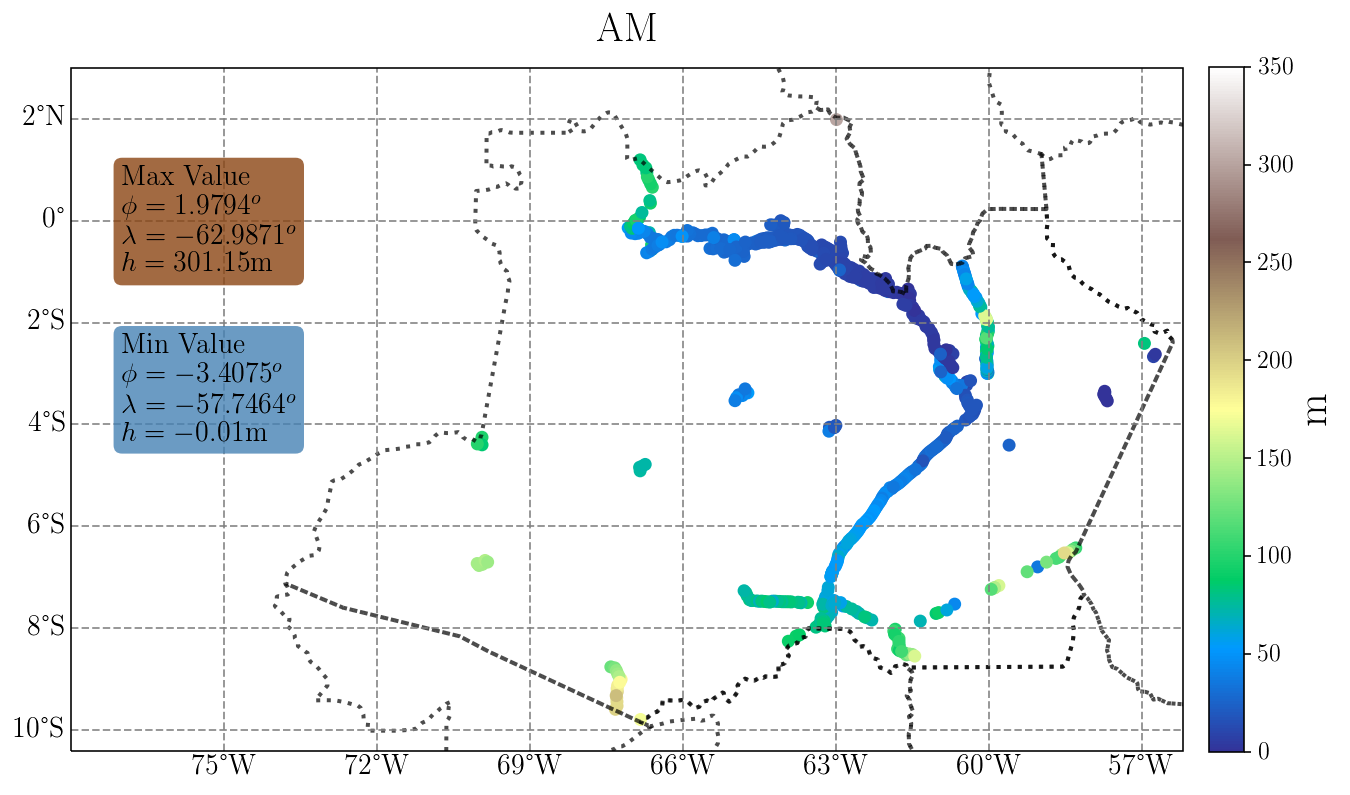

In [6]:
point_map(df.LONG, df.LAT, df.ALT, df.ALT, uf, fig_size=(12.,14.), region=[-78,-56.2,-10.4,3], \
         sign=(-77,-77,-1,-4.3), cmap='terrain', shrink=0.45, lim_val=(True,True,0.,350.))

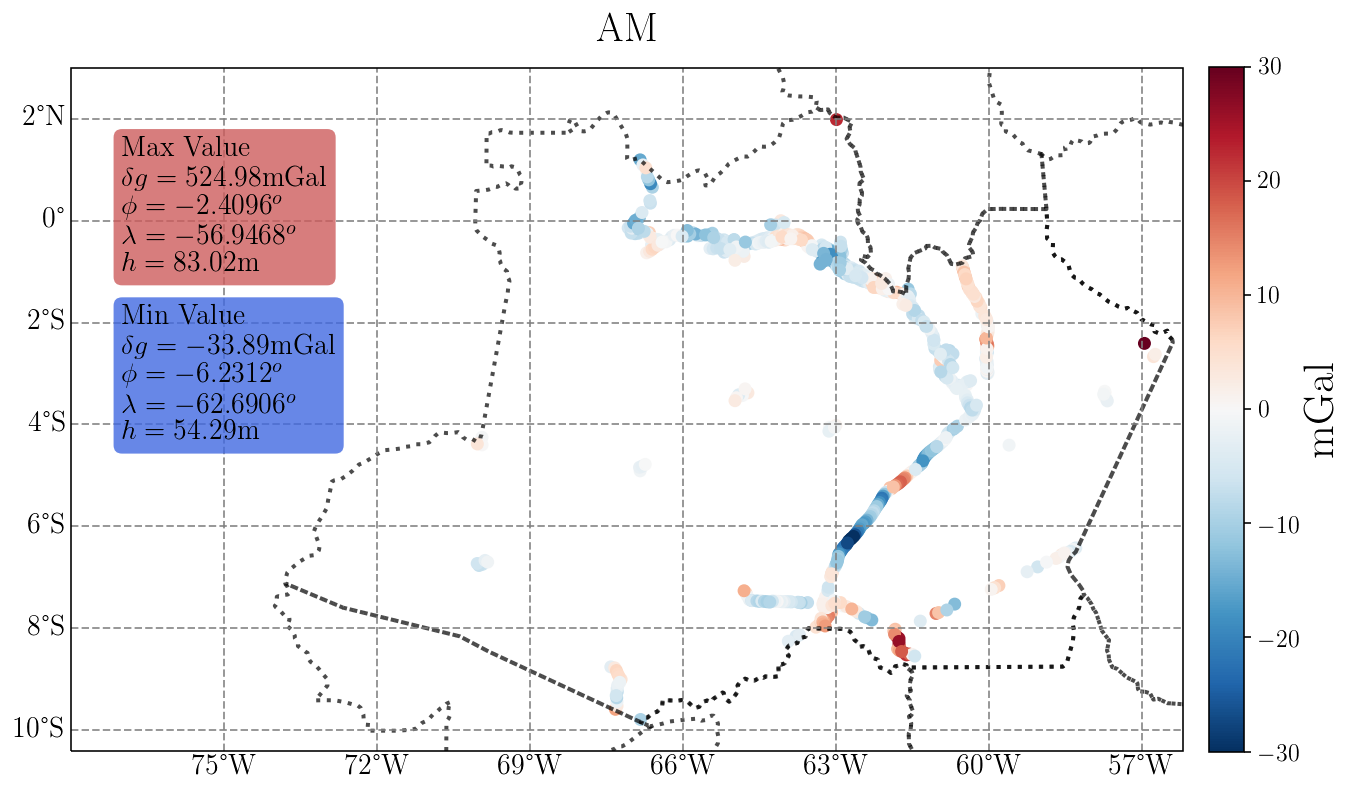

In [7]:
point_map(df.LONG, df.LAT, df.ALT, df.DIST, uf, fig_size=(12.,14.), region=[-78,-56.2,-10.4,3], \
         sign=(-77,-77,-1,-4.3), shrink=0.45, lim_val=(True, 30.))

In [8]:
index = np.argmax(df.ALT.values)
print('MAX', index, df.ALT[index], df.DIST[index])

index = np.argmin(df.ALT.values)
print('MIN', index, df.ALT[index], df.DIST[index])

MAX 657 301.15 22.6605230999412
MIN 487 -0.01 -0.8618111999239773


In [9]:
index = np.argmax(df.DIST.values)
print('MAX', index, df.ALT[index], df.DIST[index])

index = np.argmin(df.DIST.values)
print('MIN', index, df.ALT[index], df.DIST[index])

MAX 497 83.02 524.9832778000273
MIN 551 54.29 -33.8920819000341


### Calculating rotation matrices and Cartesian coordinates

In [10]:
# Calculating Cartesian coordinates
x, y, z = geodetic2cartesian(df.LONG, df.LAT, df.ALT)
R = np.array(rotation_matrix(df.LONG, df.LAT))

## Estimating the first set of point-mass parameters

In [11]:
pc = []
hc = []
indc = []
xc = []
yc = []
zc = []
Rc = []
rabs_max = []
taur = 1e-11 #1e-5 #0.05
tauc = 1e-3
it_max_l1 = 5
latc = []
lonc = []

## Iteração 1 - L2 norm

In [12]:
indl = np.arange(disturb.size)
# mi_c = 1e-5
mi_c = 1e-30
hcl = 3000. #5000. #14200. # 20000. #800. #1000.
print(hcl, type(indl)) #indl

3000.0 <class 'numpy.ndarray'>


In [13]:
rcl = disturb[indl]
xcl = x[indl]
ycl = y[indl]
zcl = z[indl]

latcl = df.LAT[indl]
loncl = df.LONG[indl]

In [14]:
Rcl = R[:, indl]

In [15]:
# Calculo de Acc_l
hlay = np.zeros(indl.size) - hcl
xlay, ylay, zlay = geodetic2cartesian(loncl, latcl, hlay)
Lay = EqLayer(df.LONG, df.LAT, np.zeros_like(df.LONG)-hcl)
layer = Lay.build_layer(xlay, ylay, zlay)
Acc_l = Lay.designMat(xcl, ycl, zcl, Rcl, layer)
print(Acc_l.shape)

(678, 678)


In [16]:
H = np.dot(Acc_l.T, Acc_l)
# H += mi_c*np.trace(H)*np.identity(indl.size)
H += (mi_c*np.trace(H)*np.identity(indl.size))/indl.size

In [17]:
p_L2 = np.linalg.solve(H, np.dot(Acc_l.T, rcl))
print(p_L2.size)
# p_L1 = L1_estim(rcl, p_L2, Acc_l, 5)

678


In [18]:
rcl -= np.dot(Acc_l, p_L2)
# print rcl[:50]

In [19]:
rabs_max_l = np.max(np.abs(rcl))
rabs_max_l

0.56878448203624

In [20]:
pc.append(p_L2)
hc.append(hcl)
indc.append(indl)
xc.append(xcl)
yc.append(ycl)
zc.append(zcl)
Rc.append(Rcl)
latc.append(latcl)
lonc.append(loncl)

In [21]:
rabs_max.append(rabs_max_l)

In [22]:
rc = rcl[:] #r1
print(np.max(np.abs(rc)))

0.56878448203624


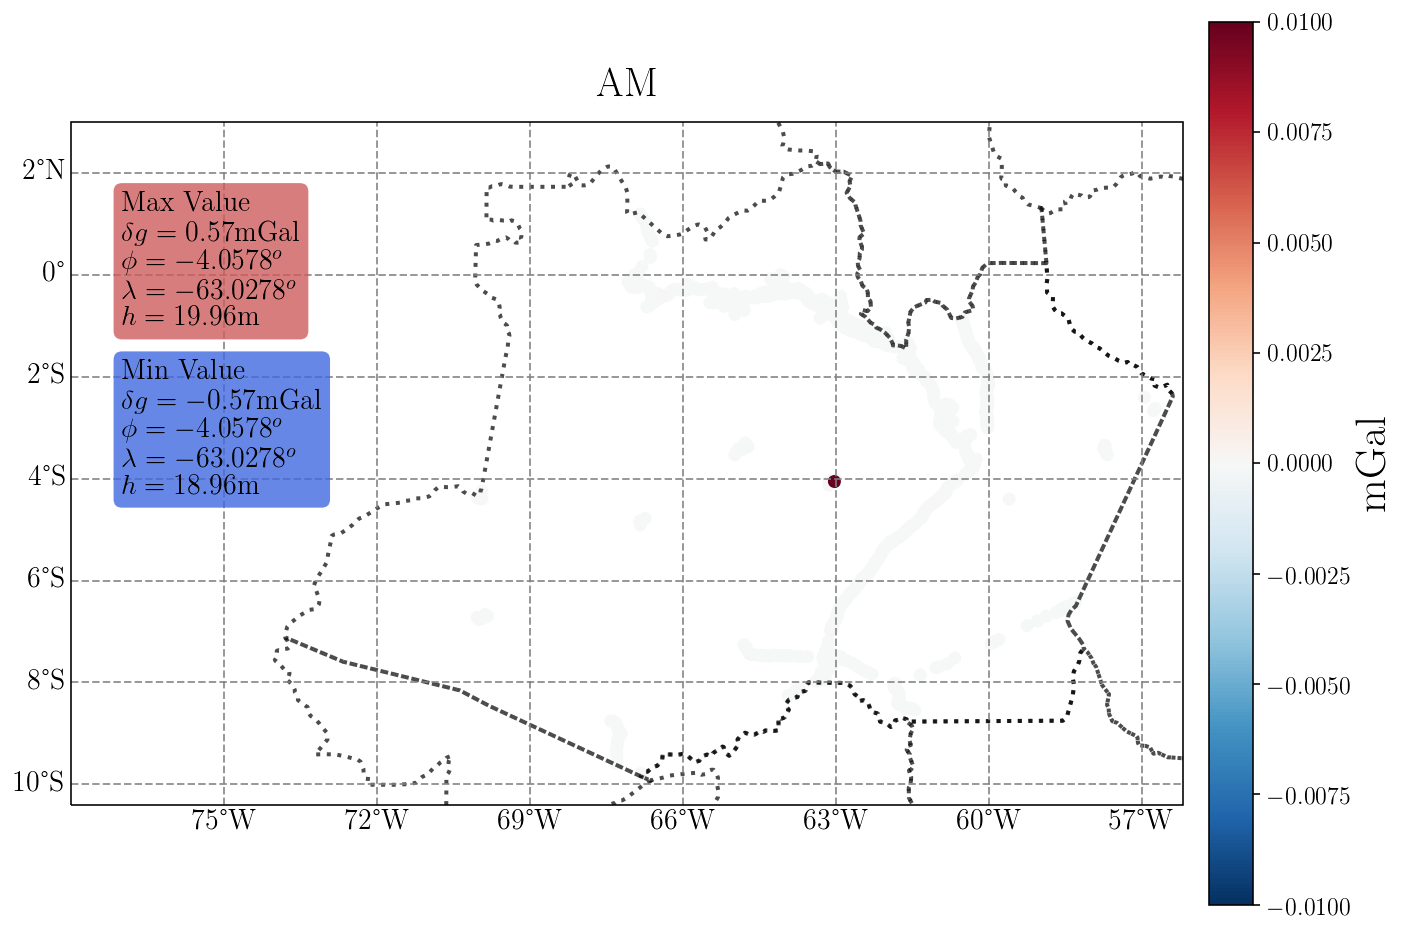

In [23]:
point_map(df.LONG, df.LAT, df.ALT, rc, uf, fig_size=(12.,14.), region=[-78,-56.2,-10.4,3], \
         sign=(-77,-77,-1,-4.3), shrink=0.58, lim_val=(True, 1e-2))

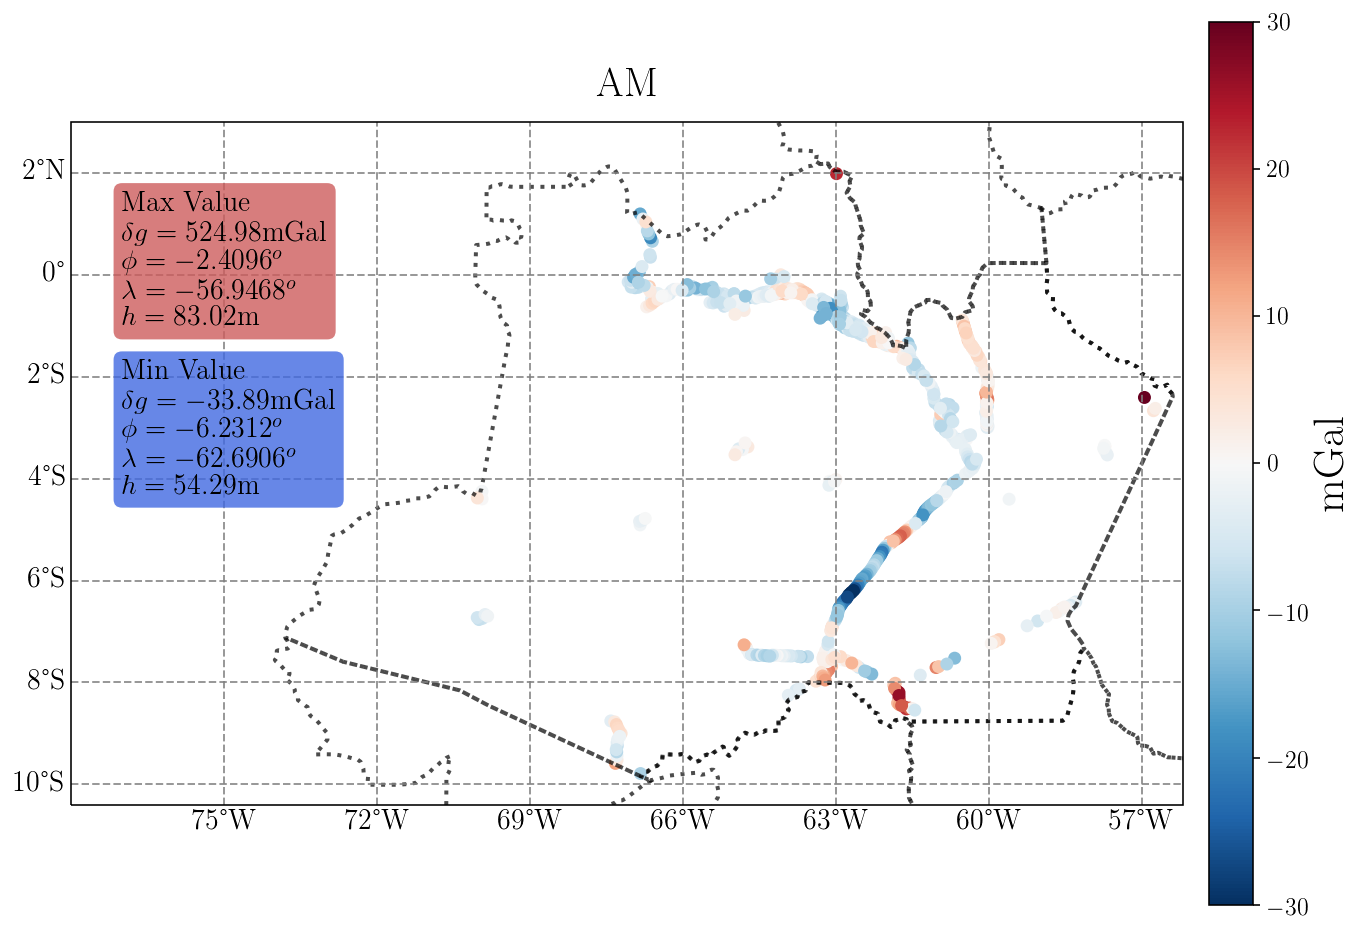

In [24]:
point_map(df.LONG, df.LAT, df.ALT, df.DIST, uf, fig_size=(12.,14.), region=[-78,-56.2,-10.4,3], \
         sign=(-77,-77,-1,-4.3), shrink=0.58, lim_val=(True, 30.))

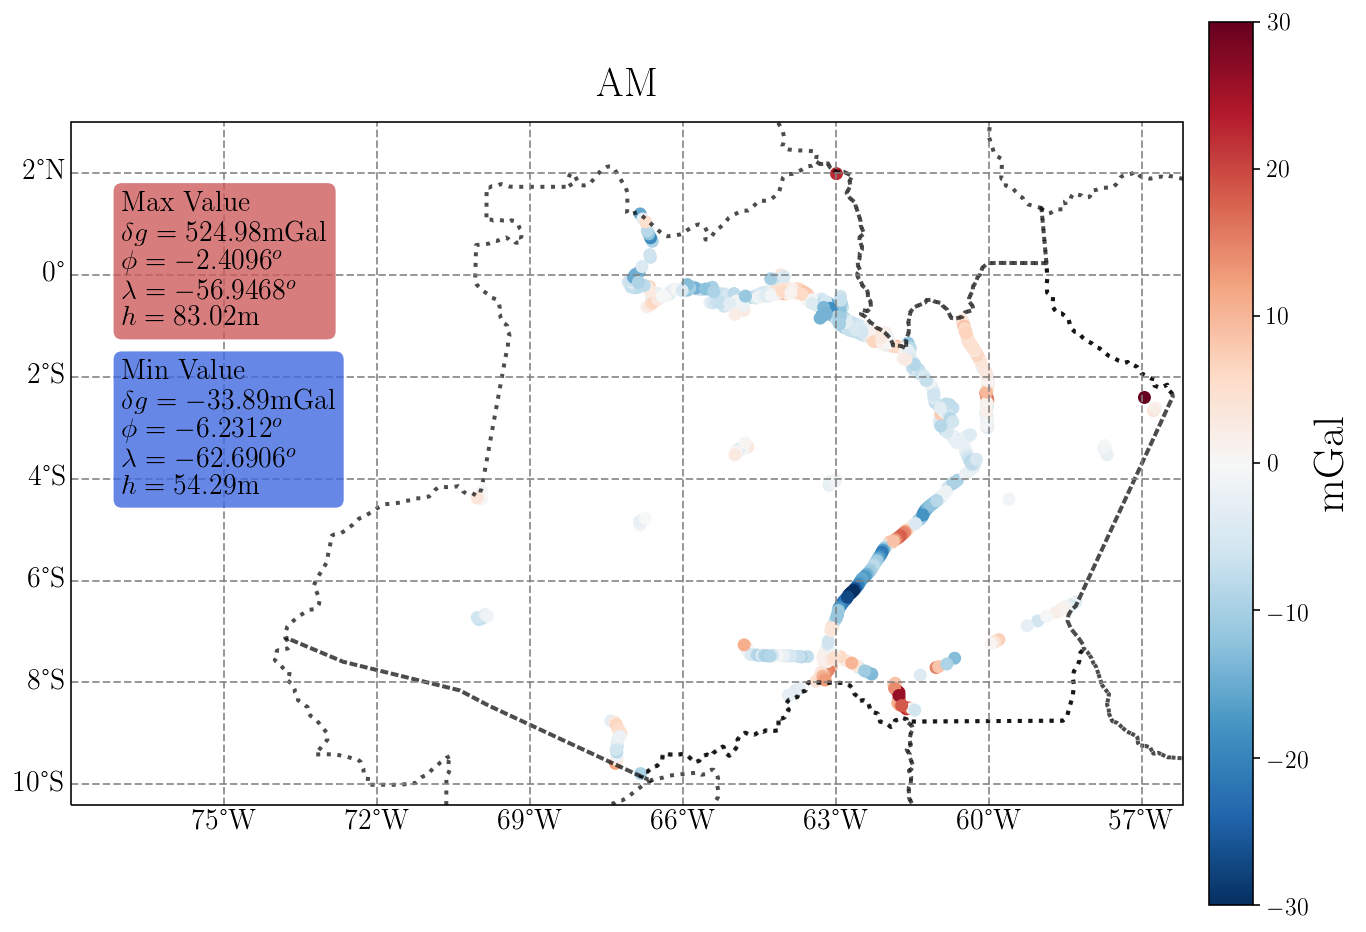

In [25]:
point_map(df.LONG, df.LAT, df.ALT, np.dot(Acc_l, p_L2), uf, fig_size=(12.,14.), region=[-78,-56.2,-10.4,3], \
         sign=(-77,-77,-1,-4.3), shrink=0.58, lim_val=(True, 30.))

In [26]:
# print(len([value for value in rc if value > 1e-5]))
# print([value for value in rc if value > 1e-5])

In [27]:
new_data = {'LONG':bdg.LONG.values, \
            'LAT':bdg.LAT.values, \
            'ALT':bdg.ALT_GEOM.values, \
            'BDG':bdg.GRAV.values, \
            'EIGEN':eigen.GRAV.values, \
            'DIST':disturb, \
            'RHO':p_L2, \
            'RESID':rc}
df = pd.DataFrame(new_data)
df

,LONG,LAT,ALT,BDG,EIGEN,DIST,RHO,RESID
0,-63.12500,-4.054700,20.110,978000.47,978000.697913,-0.227913,8.076511e+10,-5.161425e-06
1,-63.08250,-4.072800,20.110,977999.37,978002.334069,-2.964069,-9.260106e+11,-3.620356e-05
2,-63.02780,-4.057800,18.960,978000.05,978001.880598,-1.830598,-3.854716e+11,-5.683992e-01
3,-60.02640,-2.049700,50.330,978013.96,978018.357675,-4.397675,-4.543912e+12,-2.856959e-10
4,-66.99330,-0.152500,82.590,978012.05,978016.361318,-4.311318,-1.268476e+14,4.243361e-10
...,...,...,...,...,...,...,...,...
673,-61.29333,-4.713176,17.274,978032.10,978050.130307,-18.030307,-4.319599e+12,-1.792518e-09
674,-61.01841,-4.431417,29.921,978038.35,978046.777911,-8.427911,1.388061e+14,1.160085e-10
675,-61.43693,-4.881803,33.797,978037.25,978041.482689,-4.232689,-1.285784e+12,-2.524999e-09
676,-62.77205,-6.323996,60.473,978059.34,978086.479510,-27.139510,-6.756796e+12,-1.286065e-09


In [28]:
print(df.RESID.min(), df.RESID.max())

-0.5683991967502395 0.56878448203624


### Upward Continuation

In [29]:
# up_cont = Lay.continuation(df.LONG,df.LAT,6000.,df.LONG,df.LAT,-3000.,p_L2)

In [30]:
Layer = EqLayer(df.LONG, df.LAT, np.zeros_like(df.LONG)-hcl)
up_cont = Layer.continuation(df.LONG,df.LAT,3000.,-3000.,p_L2)

The transformation is an upward continuation


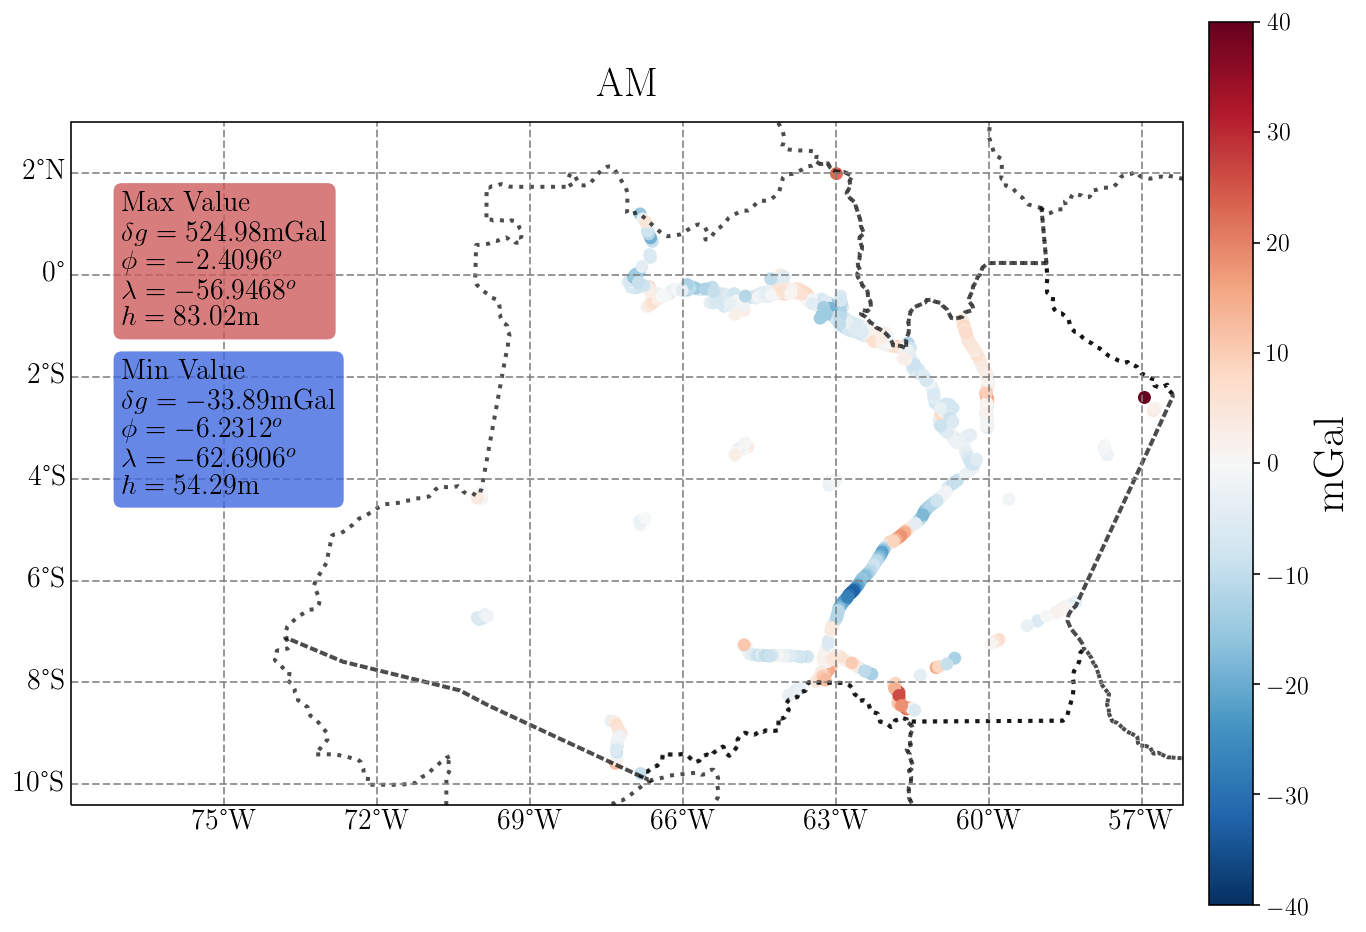

In [31]:
point_map(df.LONG, df.LAT, df.ALT, df.DIST, uf, fig_size=(12.,14.), region=[-78,-56.2,-10.4,3], \
         sign=(-77,-77,-1,-4.3), shrink=0.58, lim_val=(True, 40.))

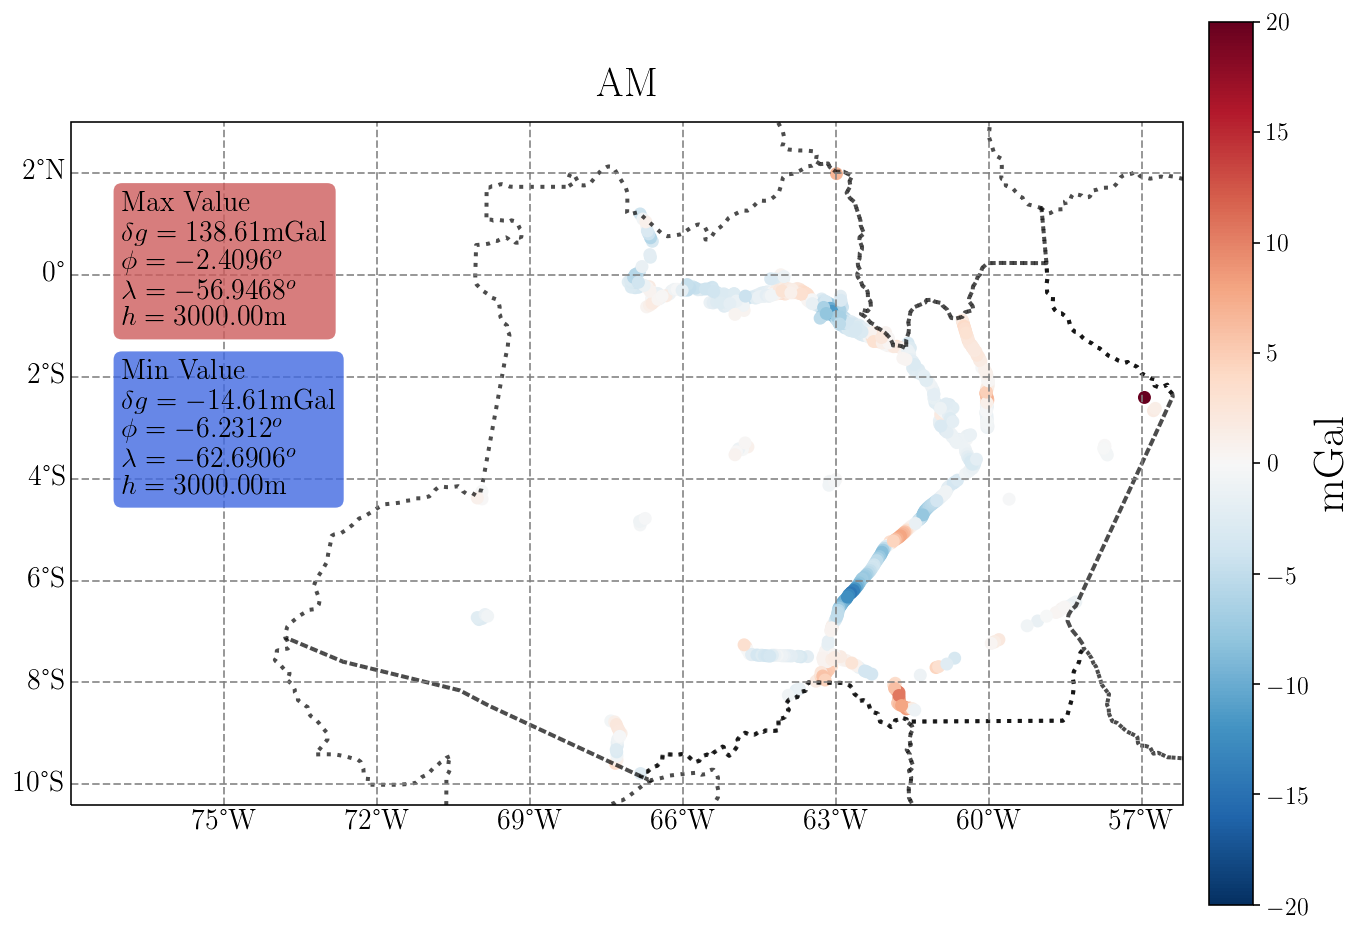

In [32]:
point_map(df.LONG, df.LAT, np.zeros_like(df.LONG)+3000., up_cont, uf, fig_size=(12.,14.), \
          region=[-78,-56.2,-10.4,3], sign=(-77,-77,-1,-4.3), shrink=0.58, lim_val=(True, 20.))

In [33]:
# Layer = EqLayer(df.LONG, df.LAT, np.zeros_like(df.LONG)-hcl)
up_cont = Layer.continuation(df.LONG,df.LAT,6000.,-3000.,p_L2)

The transformation is an upward continuation


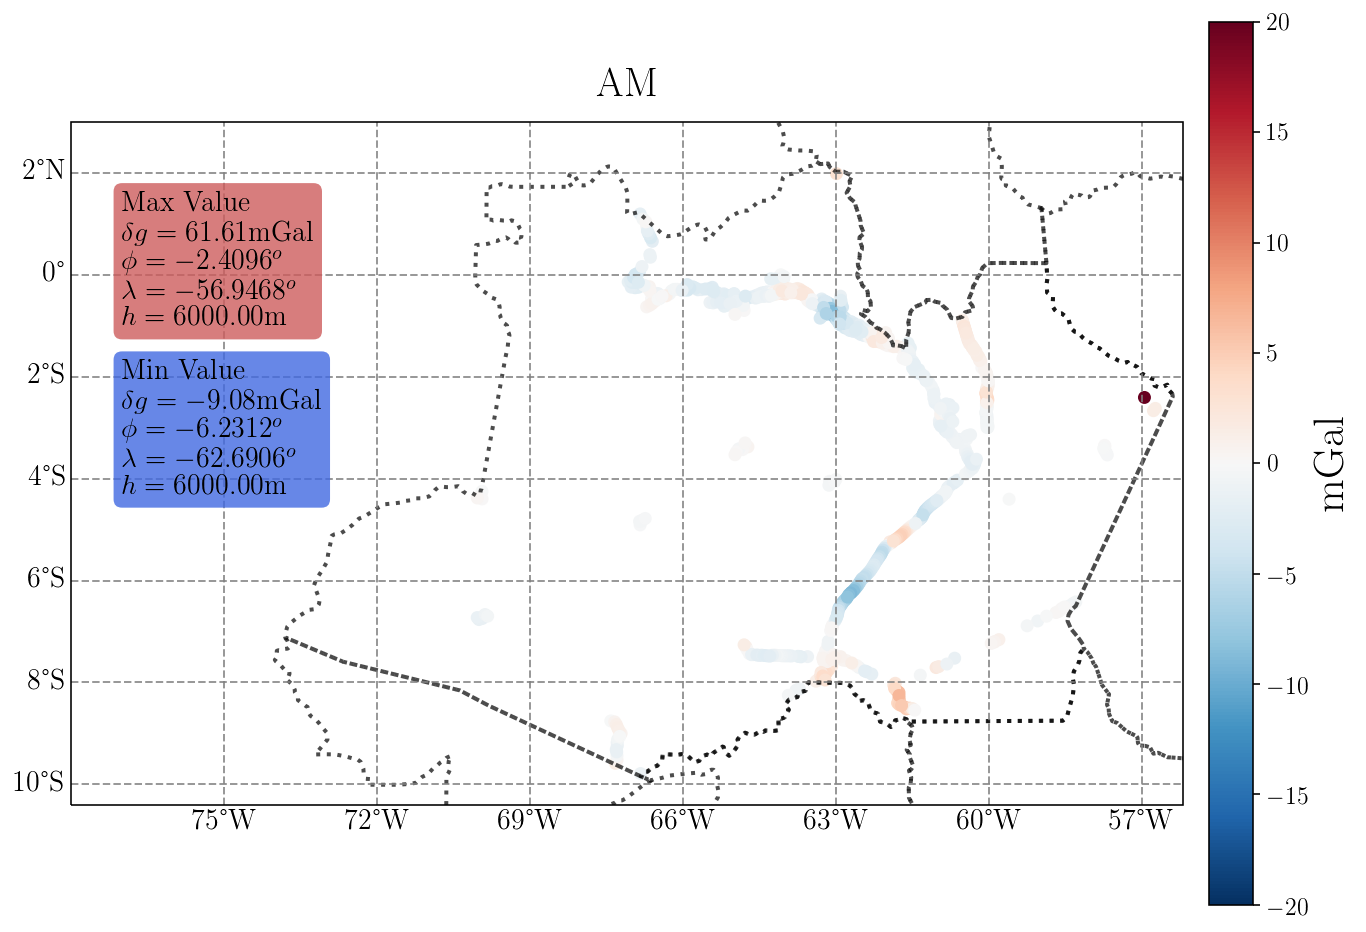

In [34]:
point_map(df.LONG, df.LAT, np.zeros_like(df.LONG)+6000., up_cont, uf, fig_size=(12.,14.), \
          region=[-78,-56.2,-10.4,3], sign=(-77,-77,-1,-4.3), shrink=0.58, lim_val=(True, 20.))

In [35]:
# Layer = EqLayer(df.LONG, df.LAT, np.zeros_like(df.LONG)-hcl)
up_cont = Layer.continuation(df.LONG,df.LAT,9000.,-3000.,p_L2)

The transformation is an upward continuation


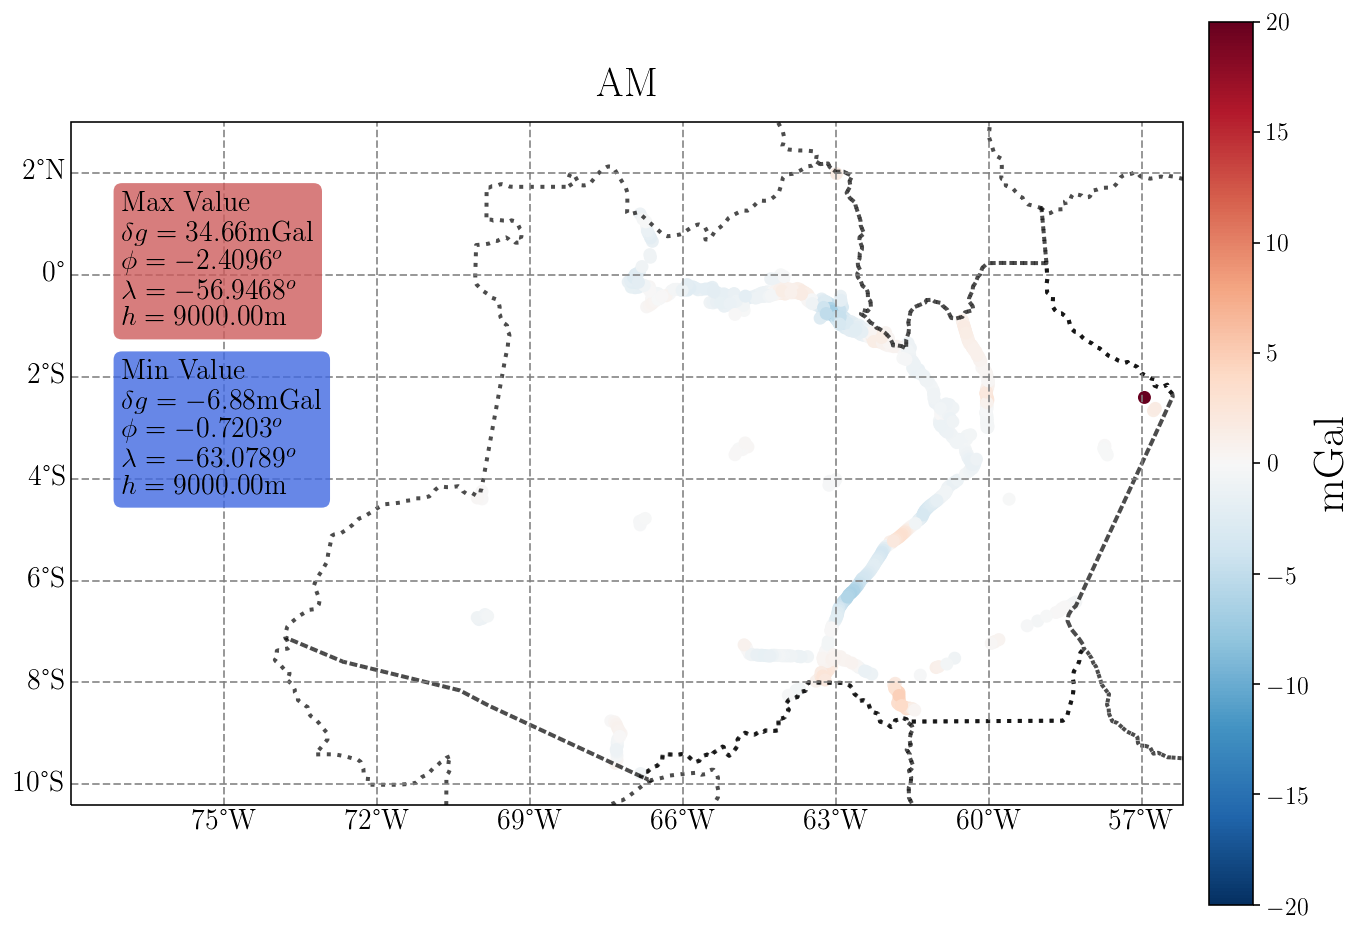

In [36]:
point_map(df.LONG, df.LAT, np.zeros_like(df.LONG)+9000., up_cont, uf, fig_size=(12.,14.), \
          region=[-78,-56.2,-10.4,3], sign=(-77,-77,-1,-4.3), shrink=0.58, lim_val=(True, 20.))